In [1]:
import numpy as np
import scipy.stats as stats
import pymc3 as pm
from theano import shared
import matplotlib.pyplot as plt
import theano
import theano.tensor as tt
floatX = "float32"

/Users/shashank/.virtualenvs/pymc3-dev/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%load_ext watermark
%watermark -v -m -p numpy,sklearn,pandas,matplotlib,seaborn,pymc3,theano

CPython 2.7.13
IPython 5.5.0

numpy 1.14.2
sklearn 0.19.1
pandas 0.21.0
matplotlib 2.1.0
seaborn 0.8.1
pymc3 3.3
theano 1.0.1

compiler   : GCC 4.2.1 Compatible Apple LLVM 8.0.0 (clang-800.0.42.1)
system     : Darwin
release    : 17.3.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit


# Set up data

In [3]:
from sklearn.datasets import make_blobs

n_samples = 50
nk = 5
random_state = 170
X, y = make_blobs(n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5, 1.5, .8], random_state=random_state, centers=5)
X = X.astype('float32')
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.viridis);

# Kmeans and deterministic GMM

In [4]:
from sklearn.cluster import KMeans

y1 = KMeans(n_clusters=nk, n_init=50).fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y1, cmap=plt.cm.viridis);
plt.title("kmean with %s clusters" %nk);

# Using Stochastic Approximation

In [5]:
batch_size = 50
X_batch = pm.data.Minibatch(data=X, 
                            batch_size=batch_size, 
                            dtype=None, 
                            broadcastable=None, 
                            name='X', 
                            random_seed=42, 
                            update_shared_f=lambda : theano.shared(X[:batch_size,]), 
                            in_memory_size=None)

In [6]:
K = 15
def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

# Log likelihood of Gaussian mixture distribution
from pymc3.math import logsumexp
solver = tt.slinalg.Solve(A_structure="lower_triangular", lower=True)
def GMM_logp(weight, mus, chol):
    def logp_(value):
        Ncomp = len(chol)
        logps = []
        for i in range(Ncomp):
            mu = mus[:, i]
            chol_cov = chol[i]
            k = chol_cov.shape[0]

            delta = value.reshape((-1, k)) - mu
            delta_trans = solver(chol_cov, delta.T)

            result = k * tt.log(2 * np.pi)
            result += 2.0 * tt.sum(tt.log(tt.nlinalg.diag(chol_cov)))
            result += (delta_trans ** 2).sum(axis=0).T
            logps.append(tt.log(weight[i]) + -0.5*result)
        return logsumexp(tt.stacklists(logps), axis=0)
    return logp_

In [7]:
with pm.Model() as model:
    alpha = pm.Gamma('alpha', 1., 1., transform=None)
    beta = pm.Beta('beta', 1., alpha, shape=K)
    w = pm.Deterministic('w', stick_breaking(beta))
                         
    sd_dist = []
    packed_chol = []
    chol = []
    for i in range(K):
        sd_dist.append(pm.HalfCauchy.dist(beta=2.5))
        packed_chol.append(pm.LKJCholeskyCov('chol_cov_%i'%i, eta=2, n=2, sd_dist=sd_dist[i]))
        chol.append(pm.expand_packed_triangular(2, packed_chol[i], lower=True))
    
    mus = pm.Normal('mu', 0, sd=10, shape=(2, K))

    obs = pm.DensityDist('obs', GMM_logp(w, mus, chol), observed=X)

In [15]:
def logp_elemwiset(model):
    """Theano scalar of log-probability of the model"""
    with model:
        
        if len(model.observed_RVs) > 1: 
            raise ValueError('logp_elemwiset can only be defined for models with 1 observed RV')
            
        logp_factors = model.observed_RVs[0].logp_elemwiset
    
        logp_potentials = tt.sum([pot.logp_elemwiset for pot in model.potentials], axis=0)
        logp = logp_factors + logp_potentials
        if model.name:
            logp.name = '__logp_%s' % model.name
        else:
            logp.name = '__logp'
        return logp

In [39]:
f = theano.function([model.basic_RVs[0]], outputs=model.basic_RVs[0].logp_elemwiset.shape)

In [52]:
f1 = theano.function([model.basic_RVs[0], model.basic_RVs[1]], outputs=model.basic_RVs[1].logp_elemwiset)

In [53]:
f1(alpha=model.test_point['alpha'], beta_logodds__=model.test_point['beta_logodds__'])

array([-1.38629436, -1.38629436, -1.38629436, -1.38629436, -1.38629436,
       -1.38629436, -1.38629436, -1.38629436, -1.38629436, -1.38629436,
       -1.38629436, -1.38629436, -1.38629436, -1.38629436, -1.38629436])

In [40]:
f(alpha=model.test_point['alpha'])

array([], dtype=int64)

In [12]:
model.observed_RVs

[obs]

In [30]:
f1 = theano.function([model.mu, model.beta_logodds__] + packed_chol, outputs=logp_elemwiset(model))

In [35]:
packed_chol

[chol_cov_0,
 chol_cov_1,
 chol_cov_2,
 chol_cov_3,
 chol_cov_4,
 chol_cov_5,
 chol_cov_6,
 chol_cov_7,
 chol_cov_8,
 chol_cov_9,
 chol_cov_10,
 chol_cov_11,
 chol_cov_12,
 chol_cov_13,
 chol_cov_14]

In [37]:
chol_dict

{'chol_cov_0': array([0., 0., 0.]),
 'chol_cov_1': array([0., 0., 0.]),
 'chol_cov_10': array([0., 0., 0.]),
 'chol_cov_11': array([0., 0., 0.]),
 'chol_cov_12': array([0., 0., 0.]),
 'chol_cov_13': array([0., 0., 0.]),
 'chol_cov_14': array([0., 0., 0.]),
 'chol_cov_2': array([0., 0., 0.]),
 'chol_cov_3': array([0., 0., 0.]),
 'chol_cov_4': array([0., 0., 0.]),
 'chol_cov_5': array([0., 0., 0.]),
 'chol_cov_6': array([0., 0., 0.]),
 'chol_cov_7': array([0., 0., 0.]),
 'chol_cov_8': array([0., 0., 0.]),
 'chol_cov_9': array([0., 0., 0.])}

In [39]:
chol_dict = {k.split('_cholesky')[0]: v + 1.0 for k, v in model.test_point.items() if k.startswith('chol_cov_')}

In [42]:
X.shape

(50, 2)

In [41]:
f1(mu=model.test_point['mu'] + 1.0, beta_logodds__=model.test_point['beta_logodds__'], **chol_dict).shape

(1, 50)

In [40]:
f1(mu=model.test_point['mu'] + 1.0, beta_logodds__=model.test_point['beta_logodds__'], **chol_dict)

array([[  -7.89958109,  -99.00254719,   -2.01120077, -130.44872385,
         -91.48974222,  -61.98245118,  -15.439933  ,   -1.84499308,
        -128.46150404,  -58.57542994,  -62.28958293, -102.85483662,
          -1.90574389,  -78.95371677,  -91.73293378,  -52.62116087,
         -81.78274185,   -5.06936401,  -89.38948698,  -47.73311237,
         -45.87983229,  -81.90853915,  -57.88191551,  -55.30523949,
         -34.37624082,  -44.73814196,   -5.11408694,  -64.90411151,
          -2.11543102,  -55.57405103,  -23.27733299,   -3.5599816 ,
         -50.94690034,  -82.61817483,  -51.69141075,  -16.14326769,
         -77.27232232,  -19.93652208, -179.02772058, -148.01738327,
        -102.63260405,  -22.78670433,   -3.87793442, -164.1218686 ,
        -129.46008133,  -28.49570964, -141.61532175,   -2.52115835,
         -42.61213346, -152.08995059]])

In [ ]:
theano.function(inputs=[], outputs=[model.basic_RVs])

In [8]:
model.dlogp_elemwisea
()

AttributeError: 'Model' object has no attribute 'logp_elemwiset'

In [72]:
with pm.Model() as model:
    alpha = pm.Gamma('alpha', 1., 1., transform=None)
    beta = pm.Beta('beta', 1., alpha, shape=K)
    w = pm.Deterministic('w', stick_breaking(beta))
                         
    sd_dist = []
    packed_chol = []
    chol = []
    for i in range(K):
        sd_dist.append(pm.HalfCauchy.dist(beta=2.5))
        packed_chol.append(pm.LKJCholeskyCov('chol_cov_%i'%i, eta=2, n=2, sd_dist=sd_dist[i]))
        chol.append(pm.expand_packed_triangular(2, packed_chol[i], lower=True))
    
    mus = pm.Normal('mu', 0, sd=10, shape=(2, K))

    obs = pm.DensityDist('obs', GMM_logp(w, mus, chol), observed=X)
    logL = obs.logp_elemwiset.sum(axis=tuple(range(1, obs.logp_elemwiset.ndim)))
    theano.grad(obs.logpt, alpha)

DisconnectedInputError: 

In [49]:
tuple(range(1, 3))

(1, 2)

In [43]:
obs_var = model.observed_RVs[0]

In [44]:
logL = obs_var.logp_elemwiset.sum(axis=tuple(range(1, obs_var.logp_elemwiset.ndim)))

In [45]:
theano.grad(logL[0], alpha)

DisconnectedInputError: 

In [108]:
le = obs.distribution.logp(theano.shared(X))

In [ ]:
with model:
    tr = pm.sample(draws=100, model=model)

In [9]:
def elemwise_dlogL(vars, model, flat_view):
    """
    Returns Jacobian of the log likelihood for each training datum wrt vars
    as a matrix of size N x D
    """
    # select one observed random variable
    obs_var = model.observed_RVs[0]
    # tensor of shape (batch_size,)
    logL = obs_var.logp_elemwiset.sum(axis=tuple(range(1, obs_var.logp_elemwiset.ndim)))
    # calculate fisher information
    terms = []
    for var in vars:
        output, _ =  theano.scan(lambda i, logX=logL, v=var: theano.grad(logX[i], v).flatten(),\
                           sequences=[tt.arange(logL.shape[0])])
        terms.append(output)
    dlogL = theano.clone(
        tt.concatenate(terms, axis=1), flat_view.replacements, strict=False)
    return dlogL

In [26]:
model.vars

[alpha_log__,
 beta_logodds__,
 chol_cov_0_cholesky_cov_packed__,
 chol_cov_1_cholesky_cov_packed__,
 chol_cov_2_cholesky_cov_packed__,
 chol_cov_3_cholesky_cov_packed__,
 chol_cov_4_cholesky_cov_packed__,
 chol_cov_5_cholesky_cov_packed__,
 chol_cov_6_cholesky_cov_packed__,
 chol_cov_7_cholesky_cov_packed__,
 chol_cov_8_cholesky_cov_packed__,
 chol_cov_9_cholesky_cov_packed__,
 chol_cov_10_cholesky_cov_packed__,
 chol_cov_11_cholesky_cov_packed__,
 chol_cov_12_cholesky_cov_packed__,
 chol_cov_13_cholesky_cov_packed__,
 chol_cov_14_cholesky_cov_packed__,
 mu]

In [22]:
logL.shape

Shape.0

In [28]:
theano.grad(logL[0], model.vars[1])

Elemwise{neg}.0

In [24]:
# select one observed random variable
obs_var = model.observed_RVs[0]
# tensor of shape (batch_size,)
logL = obs_var.logp_elemwiset.sum(
    axis=tuple(range(1, obs_var.logp_elemwiset.ndim)))
# calculate fisher information
terms = []
print(obs_var)
for var in model.vars[1:]:
    print(var)
    output, _ = theano.scan(lambda i, logX=logL, v=var: theano.grad(logX[i], v).flatten(),\
                            sequences=[tt.arange(logL.shape[0])])

obs
beta_logodds__


KeyboardInterrupt: 

In [12]:
model.observed_RVs[0]

[obs]

In [11]:
with model:
    tr = pm.sample(draws=100, model=model, step=pm.SGFS(total_size=50, batch_size=50))

DisconnectedInputError: 

In [83]:
obs_var = model.observed_RVs[0]

In [84]:
logL = obs_var.logp_elemwiset.sum(
        axis=tuple(range(1, obs_var.logp_elemwiset.ndim)))

In [101]:
model.vars

[alpha_log__,
 beta_logodds__,
 chol_cov_0_cholesky_cov_packed__,
 chol_cov_1_cholesky_cov_packed__,
 chol_cov_2_cholesky_cov_packed__,
 chol_cov_3_cholesky_cov_packed__,
 chol_cov_4_cholesky_cov_packed__,
 chol_cov_5_cholesky_cov_packed__,
 chol_cov_6_cholesky_cov_packed__,
 chol_cov_7_cholesky_cov_packed__,
 chol_cov_8_cholesky_cov_packed__,
 chol_cov_9_cholesky_cov_packed__,
 chol_cov_10_cholesky_cov_packed__,
 chol_cov_11_cholesky_cov_packed__,
 chol_cov_12_cholesky_cov_packed__,
 chol_cov_13_cholesky_cov_packed__,
 chol_cov_14_cholesky_cov_packed__,
 mu]

In [107]:
obs_var.logp_elemwiset.nonzero_values().eval()

MissingInputError: Input 0 of the graph (indices start from 0), used to compute Subtensor{::, int64}(mu, Constant{14}), was not provided and not given a value. Use the Theano flag exception_verbosity='high', for more information on this error.

In [94]:
obs_var.logp_elemwiset.eval(X)

AttributeError: 'numpy.ndarray' object has no attribute 'keys'

In [89]:
# calculate fisher information
terms = []
for var in model.vars:
    output, _ =  theano.scan(lambda i, logX=logL, v=var: theano.grad(logX[i], v).flatten(),\
                       sequences=[tt.arange(logL.shape[0])])
    terms.append(output)

DisconnectedInputError: 

In [86]:
model.vars

[alpha_log__,
 beta_logodds__,
 chol_cov_0_cholesky_cov_packed__,
 chol_cov_1_cholesky_cov_packed__,
 chol_cov_2_cholesky_cov_packed__,
 chol_cov_3_cholesky_cov_packed__,
 chol_cov_4_cholesky_cov_packed__,
 chol_cov_5_cholesky_cov_packed__,
 chol_cov_6_cholesky_cov_packed__,
 chol_cov_7_cholesky_cov_packed__,
 chol_cov_8_cholesky_cov_packed__,
 chol_cov_9_cholesky_cov_packed__,
 chol_cov_10_cholesky_cov_packed__,
 chol_cov_11_cholesky_cov_packed__,
 chol_cov_12_cholesky_cov_packed__,
 chol_cov_13_cholesky_cov_packed__,
 chol_cov_14_cholesky_cov_packed__,
 mu]

In [82]:
with model:
    step_method = pm.step_methods.SGFS(batch_size=50, total_size=X.shape[0])
#     trace = pm.sample(step=step_method, samples=5000, vars=model.vars)

DisconnectedInputError: 

In [ ]:
step_method.

In [ ]:
K = 1
with pm.Model() as model:
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1., alpha, shape=K)
    w = pm.Deterministic('w', stick_breaking(beta))
                         
    sd_dist = []
    packed_chol = []
    chol = []
    for i in range(K):
        sd_dist.append(pm.HalfCauchy.dist(beta=2.5))
        packed_chol.append(pm.LKJCholeskyCov('chol_cov_%i'%i, eta=2, n=2, sd_dist=sd_dist[i]))
        chol.append(pm.expand_packed_triangular(2, packed_chol[i], lower=True))
    
    mus = pm.Normal('mu', 0, sd=10, shape=(2, K))
    obs = pm.DensityDist('obs', GMM_logp(w, mus, chol), observed=obs_input)
    
    
    step_method = pm.step_methods.SGFS(batch_size=50, 
                                       total_size=X.shape[0],
                                       minibatches=minibatches,
                                       minibatch_tensors=minibatch_tensors)
    s.set_value(0)
#     # It is time to set `s` to zeroa
    
#     
#     trace = pm.sample(step=step_method, samples=5000, vars=model.vars)

In [ ]:
trace = pm.sample(step=step_method, samples=5000, vars=model.vars)

In [9]:
burnin=0
dpgmm.weights_ = trace[burnin:]['w'].mean(axis=0)
dpgmm.means_ = trace[burnin:]['mu'].mean(axis=0).T

In [10]:
cov_pymc3 = []
idx = np.tril_indices(2)
for i in range(K):
    chol = np.zeros((2, 2))
    chol[idx] = trace[burnin:]['chol_cov_%i'%i].mean(axis=0)
    cov_pymc3.append(np.dot(chol, chol.T))
cov_pymc3 = np.asarray(cov_pymc3)
cov_pymc3.shape

dpgmm.covariances_ = cov_pymc3

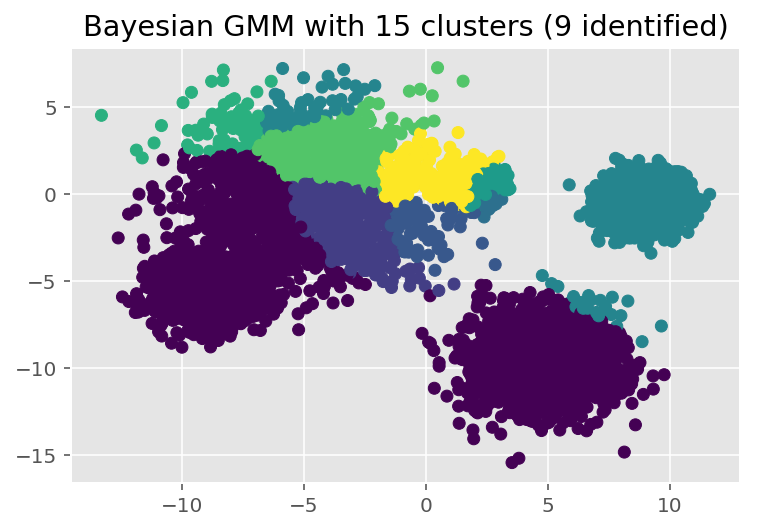

In [11]:
y3 = dpgmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y3, cmap=plt.cm.viridis);
plt.title("Bayesian GMM with %s clusters (%s identified)" % (K, len(np.unique(y3))));

# Using Edward

based on https://github.com/blei-lab/edward/blob/master/notebooks/unsupervised.ipynb

The Joint Version, which includes an explicit latent variable for the mixture assignments.

In [12]:
import tensorflow as tf
import edward as ed
from edward.models import Dirichlet, InverseGamma, MultivariateNormalDiag, \
    Normal, ParamMixture, Empirical
    
N, D = X.shape
pi = Dirichlet(tf.ones(K))
mu = Normal(tf.zeros(D), tf.ones(D), sample_shape=K)
sigmasq = InverseGamma(tf.ones(D), tf.ones(D), sample_shape=K)
x = ParamMixture(pi, {'loc': mu, 'scale_diag': tf.sqrt(sigmasq)}, MultivariateNormalDiag,
                 sample_shape=N)
z = x.cat

Inference (using the Joint version)

In [14]:
T = 5000  # number of MCMC samples
qpi = Empirical(tf.Variable(tf.ones([T, K]) / K))
qmu = Empirical(tf.Variable(tf.zeros([T, K, D])))
qsigmasq = Empirical(tf.Variable(tf.ones([T, K, D])))
qz = Empirical(tf.Variable(tf.zeros([T, N], dtype=tf.int32)))

inference = ed.Gibbs({pi: qpi, mu: qmu, sigmasq: qsigmasq, z: qz}, data={x: X})
inference.initialize()

sess = ed.get_session()
tf.global_variables_initializer().run()

t_ph = tf.placeholder(tf.int32, [])
running_cluster_means = tf.reduce_mean(qmu.params[:t_ph], 0)

for _ in range(inference.n_iter):
    info_dict = inference.update()
    inference.print_progress(info_dict)
    t = info_dict['t']
    if t % inference.n_print == 0:
        # print("\nInferred cluster means:")
        sess.run(running_cluster_means, {t_ph: t - 1})

5000/5000 [100%] ██████████████████████████████ Elapsed: 980s | Acceptance Rate: 1.000


In [15]:
# Calculate likelihood for each data point and cluster assignment,
# averaged over many posterior samples. ``x_post`` has shape (N, 100, K, D).
mu_sample = qmu.sample(100)
sigmasq_sample = qsigmasq.sample(100)
x_post = Normal(loc=tf.ones([N, 1, 1, 1]) * mu_sample,
                scale=tf.ones([N, 1, 1, 1]) * tf.sqrt(sigmasq_sample))
x_broadcasted = tf.tile(tf.reshape(X, [N, 1, 1, D]), [1, 100, K, 1])

# Sum over latent dimension, then average over posterior samples.
# ``log_liks`` ends up with shape (N, K).
log_liks = x_post.log_prob(x_broadcasted)
log_liks = tf.reduce_sum(log_liks, 3)
log_liks = tf.reduce_mean(log_liks, 1)

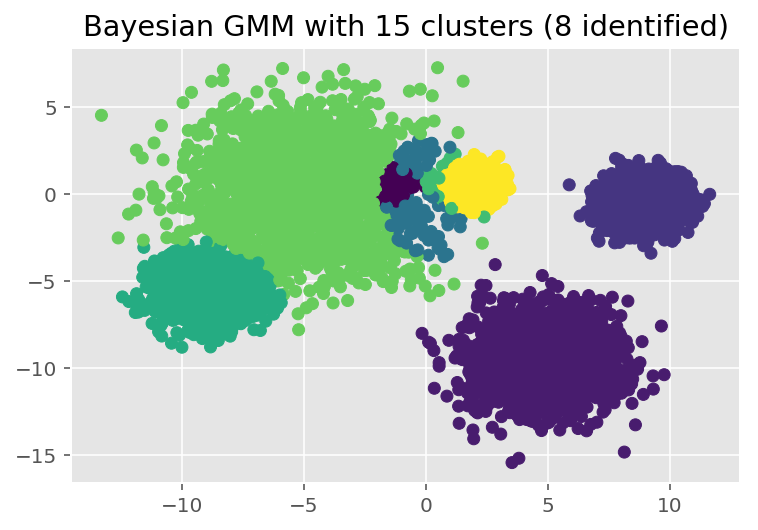

In [16]:
y4 = tf.argmax(log_liks, 1).eval()
plt.scatter(X[:, 0], X[:, 1], c=y4, cmap=plt.cm.viridis);
plt.title("Bayesian GMM with %s clusters (%s identified)" % (K, len(np.unique(y4))));